In [2]:
import torch
import torchvision.models as models
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms
import os
from PIL import Image

import cv2
import matplotlib.pyplot as plt
import numpy as np

In [3]:
train_data_path = r'data_road/training/image_2'
train_gt_path = r'data_road/training/image_2'

In [4]:
class RoadSegmentationDataset(Dataset):
    def __init__(self, image_dir, image_transform=None , label_transform=None):
        self.image_dir = image_dir
        # self.label_dir = label_dir
        self.image_transform = image_transform
        self.label_transform = label_transform
        self.image_names = os.listdir(image_dir)
        # self.masks_names = os.listdir(label_dir)

    def __len__(self):
        return len(self.image_names)

    def __getitem__(self, idx):
        image_name = self.image_names[idx]
        # mask_name = self.masks_names[idx]
        image_path = os.path.join(self.image_dir, image_name)
        # label_path = os.path.join(self.label_dir, mask_name)

        

        # Generate the corresponding mask path based on the naming convention
        mask_path = image_path.replace("image_2", "gt_image_2")
        mask_path = mask_path.replace("um_", "um_road_")
        mask_path = mask_path.replace("umm_", "umm_road_")
        mask_path = mask_path.replace("uu_", "uu_road_")

        # label = Image.open(label_path).convert("L")  # assuming labels are in grayscale

        # Read the image and mask
        image = Image.open(image_path).convert("RGB")
        mask = Image.open(mask_path).convert("RGB")
        mask = np.array(mask)

        road_label = np.array([255, 0, 255])
        
        # Create a binary mask where road areas are 1 and non-road areas are 0
        binary_mask = np.all(mask == road_label, axis=-1).astype(np.uint8)
        binary_mask = np.expand_dims(binary_mask, axis=-1)  # Add channel dimension

        binary_mask = Image.fromarray(binary_mask.squeeze() * 255)  # Scale up to 255 for visualization

        # Apply transformations if provided
        if self.image_transform:
            image = self.image_transform(image)
        
        if self.label_transform:
            binary_mask = self.label_transform(binary_mask)
        else:
            # Convert mask to tensor without additional transformations
            binary_mask = transforms.ToTensor()(binary_mask)

        return {'image': image, 'segmentation_mask': binary_mask}


In [5]:
# Define the transformations for the images
image_transform = transforms.Compose([
    transforms.Resize((256, 256)),  # Resize images to a fixed size
    transforms.ToTensor(),  # Convert images to PyTorch tensors
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),  # Normalize the image
])

# Define the transformations for the labels (only resizing and converting to tensor)
label_transform = transforms.Compose([
    transforms.Resize((256, 256)),  # Resize labels to a fixed size
    transforms.ToTensor(),  # Convert labels to PyTorch tensors
])

In [6]:
dataset = RoadSegmentationDataset(image_dir=train_data_path , image_transform=image_transform , label_transform=label_transform)
dataloader = DataLoader(dataset, batch_size=4, shuffle=True, num_workers=2)

In [7]:
dataset[0]

{'image': tensor([[[-1.6555, -1.6555, -1.6555,  ..., -1.5699, -1.9124, -1.3815],
          [-1.6555, -1.6727, -1.6727,  ..., -1.5357, -1.8953, -1.1760],
          [-1.6555, -1.6727, -1.6555,  ..., -1.6213, -1.5870, -0.1314],
          ...,
          [ 0.1254, -0.0458,  0.0227,  ..., -0.8164, -0.7479, -0.7993],
          [ 0.0741, -0.0116, -0.0116,  ..., -0.9877, -0.9877, -1.2959],
          [ 0.1254, -0.0116, -0.0972,  ..., -1.1075, -1.3130, -1.2274]],
 
         [[-1.6331, -1.6681, -1.6681,  ..., -1.5805, -1.7906, -0.4951],
          [-1.6506, -1.6506, -1.6681,  ..., -1.4405, -1.7031, -0.1099],
          [-1.6506, -1.6506, -1.6681,  ..., -1.5455, -1.2304,  0.9755],
          ...,
          [ 0.2052,  0.0826,  0.1352,  ..., -1.0378, -1.0378, -1.1429],
          [ 0.1352,  0.0826,  0.1527,  ..., -1.1429, -1.3004, -1.4755],
          [ 0.1352,  0.1702,  0.1001,  ..., -1.1954, -1.4405, -1.4755]],
 
         [[-1.4210, -1.4384, -1.4210,  ..., -1.0550, -1.5430, -0.3230],
          [-1.4036,

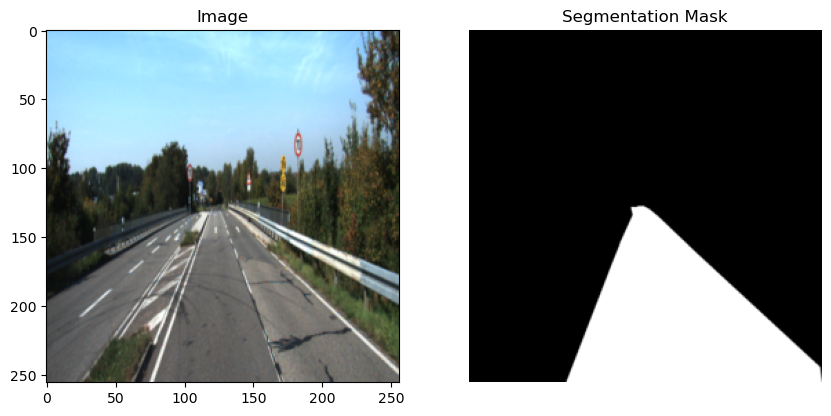

In [8]:
def show_image_and_label(dataset, idx):
    data = dataset[idx]
    image, mask = data['image'], data['segmentation_mask']
    inv_normalize = transforms.Normalize(
            mean=[-0.485 / 0.229, -0.456 / 0.224, -0.406 / 0.225],
            std=[1/0.229, 1/0.224, 1/0.225]
        )
    image = inv_normalize(image)
    image = image.permute(1, 2, 0).numpy()
    image = (image * 255).astype(np.uint8) 
    mask = mask.squeeze().numpy()

    plt.figure(figsize=(10, 5))
        
    plt.subplot(1, 2, 1)
    plt.imshow(image)
    plt.title('Image')

    plt.subplot(1, 2, 2)
    plt.imshow(mask, cmap='gray')
    plt.title('Segmentation Mask')
    plt.axis('off')

    plt.show()

show_image_and_label(dataset, 10)